# <span style="color:#0b486b">SIT307 - Assessment 2</span>

## <span style="color:#0b486b">Machine Learning</span>

Interpreting relevant data to predict future outcomes

### Import Libraries

In [98]:
from scipy import stats
from scipy.stats import zscore
from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

### Load CSV

In [99]:
df = pd.read_csv('../Data/vehicles_clean.csv')
df

,id,region,price,year,manufacturer,model,fuel,odometer,transmission,drive,type,paint_color,state
0,7088743681,greensboro,3995,2004.0,honda,element,gas,212526.0,automatic,fwd,SUV,orange,nc
1,7088741418,greensboro,10995,2014.0,chevrolet,traverse,gas,112383.0,automatic,fwd,SUV,black,nc
2,7088737004,greensboro,3995,2007.0,toyota,solara,gas,185123.0,automatic,fwd,convertible,black,nc
3,7088732376,greensboro,7995,2008.0,nissan,frontier,gas,162214.0,automatic,fwd,pickup,red,nc
4,7093461424,denver,7995,2010.0,chevrolet,silverado 1500 4wd,gas,194050.0,automatic,4wd,truck,white,co
...,...,...,...,...,...,...,...,...,...,...,...,...,...
218582,7088767324,greensboro,6695,2012.0,volvo,s60,gas,121898.0,automatic,fwd,sedan,silver,nc
218583,7076307686,syracuse,6300,2014.0,nissan,altima,gas,85000.0,automatic,fwd,sedan,grey,ny
218584,7093462901,denver,5295,2006.0,audi,a4 2.0t avant quattro,gas,150000.0,automatic,4wd,wagon,custom,co
218585,7088752165,greensboro,13995,2016.0,nissan,frontier,gas,97545.0,automatic,4wd,pickup,silver,nc


### Check Data Cleaning

Text(0.5, 1.0, 'price vs year')

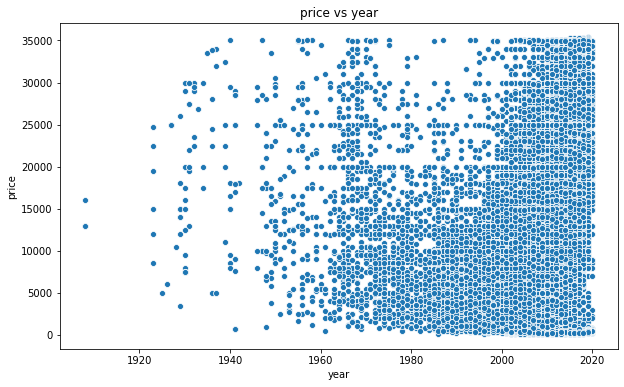

In [239]:
test_y_axis = 'price'
test_x_axis = 'year'
plt.figure(figsize=(10,6))
sns.scatterplot(x=test_x_axis,y=test_y_axis, data=df)
plt.title('{} vs {}'.format(test_y_axis,test_x_axis))

From this it is possible to see how the previous cleaning was not up to scratch.  IF we look at the z score for each year and manufacturing grouping we can ensre that the data is of a higher standard.

In [240]:
def tester(df,item):
    df['zscore']=df.groupby(['year', 'manufacturer'])[item].transform(lambda x : zscore(x,ddof=1))
    d = df[df['zscore'] < 1]
    dd = d[df['zscore'] > -1]
    return dd

In [241]:
d = tester(df,'price')
dd = tester(d,'odometer')

C:\Users\lachlan.mcinnes\Anaconda3\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\lachlan.mcinnes\Anaconda3\lib\site-packages\numpy\core\_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\lachlan.mcinnes\Anaconda3\lib\site-packages\scipy\stats\stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
C:\Users\lachlan.mcinnes\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'price vs year')

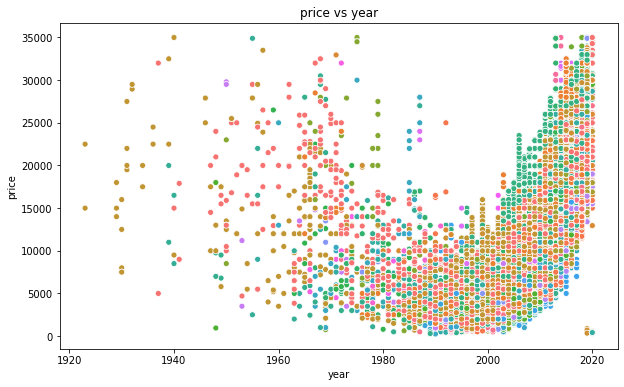

In [242]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=test_x_axis,y=test_y_axis, data=dd, hue='manufacturer', legend=False)
plt.title('{} vs {}'.format(test_y_axis,test_x_axis))

Although hard to see, the addd cleaning of data has shown a clearer relationship n the data.  This can be taken further by showing a single manufacturer type as shown below.

Text(0.5, 1.0, 'price vs year')

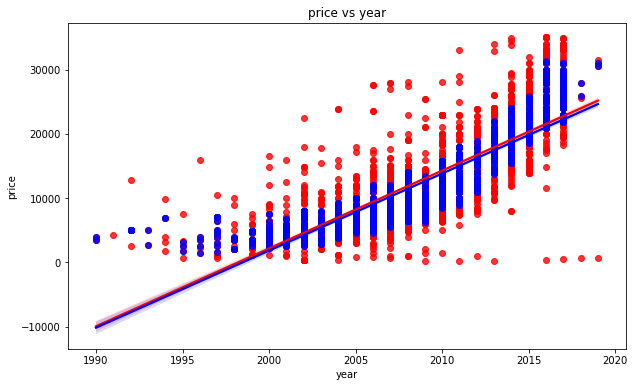

In [244]:

plt.figure(figsize=(10,6))
sns.regplot(x=test_x_axis,y=test_y_axis, data=df[df['manufacturer']=='lexus'], color='red', order=1)
sns.regplot(x=test_x_axis,y=test_y_axis, data=dd[dd['manufacturer']=='lexus'], color='blue', order=1)
plt.title('{} vs {}'.format(test_y_axis,test_x_axis))

### Convert String to Numeric

In [245]:
man = dd['manufacturer'].unique()
man.sort()
state = dd['state'].unique()
state.sort()
dic={}
for count, val in enumerate(man):
    dic[val]=count
for count, val in enumerate(state):
    dic[val]=count
    
print(dic)

{'acura': 0, 'alfa-romeo': 1, 'audi': 2, 'bmw': 3, 'buick': 4, 'cadillac': 5, 'chevrolet': 6, 'chrysler': 7, 'datsun': 8, 'dodge': 9, 'fiat': 10, 'ford': 11, 'gmc': 12, 'harley-davidson': 13, 'honda': 14, 'hyundai': 15, 'infiniti': 16, 'jaguar': 17, 'jeep': 18, 'kia': 19, 'land rover': 20, 'lexus': 21, 'lincoln': 22, 'mazda': 23, 'mercedes-benz': 24, 'mercury': 25, 'mini': 26, 'mitsubishi': 27, 'nissan': 28, 'pontiac': 29, 'porche': 30, 'ram': 31, 'rover': 32, 'saturn': 33, 'subaru': 34, 'tesla': 35, 'toyota': 36, 'volkswagen': 37, 'volvo': 38, 'ak': 0, 'al': 1, 'ar': 2, 'az': 3, 'ca': 4, 'co': 5, 'ct': 6, 'dc': 7, 'de': 8, 'fl': 9, 'ga': 10, 'hi': 11, 'ia': 12, 'id': 13, 'il': 14, 'in': 15, 'ks': 16, 'ky': 17, 'la': 18, 'ma': 19, 'md': 20, 'me': 21, 'mi': 22, 'mn': 23, 'mo': 24, 'ms': 25, 'mt': 26, 'nc': 27, 'nd': 28, 'ne': 29, 'nh': 30, 'nj': 31, 'nm': 32, 'nv': 33, 'ny': 34, 'oh': 35, 'ok': 36, 'or': 37, 'pa': 38, 'ri': 39, 'sc': 40, 'sd': 41, 'tn': 42, 'tx': 43, 'ut': 44, 'va': 45,

In [246]:
#running test for manufacturer == 'lexus'
replace = dd[dd['manufacturer']=='lexus'].replace(dic)

In [247]:
replace

,id,region,price,year,manufacturer,model,fuel,odometer,transmission,drive,type,paint_color,state,zscore
19,7082734461,richmond,29650,2017.0,21,rx 350,gas,44389.0,automatic,4wd,SUV,silver,45,0.702047
61,7085460721,"quad cities, IA/IL",8000,2005.0,21,ls 430,gas,116048.0,automatic,rwd,sedan,white,14,-0.897860
364,7079489517,utica-rome-oneida,11995,2012.0,21,is 250 awd,gas,61205.0,automatic,4wd,sedan,red,34,-0.976569
520,7087008896,greensboro,21900,2017.0,21,ct 200h hatchback 4d,gas,25010.0,automatic,fwd,hatchback,white,27,-0.498148
595,7086962237,greensboro,21900,2017.0,21,ct 200h hatchback 4d,gas,25010.0,automatic,fwd,hatchback,white,27,-0.498148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217724,7086610221,eastern NC,11700,2011.0,21,es,gas,97831.0,automatic,fwd,sedan,blue,27,-0.250314
217876,7091506675,nashville,9999,2010.0,21,es,gas,124929.0,automatic,fwd,sedan,silver,42,0.385341
217964,7091471531,nashville,28950,2017.0,21,es,gas,22293.0,automatic,fwd,sedan,silver,42,-0.666420
218266,7087748364,"quad cities, IA/IL",7299,2009.0,21,is 250,gas,121714.0,automatic,rwd,sedan,red,14,-0.076254


### Decision Tree

In [221]:
feature_cols = ['odometer']
X = replace[feature_cols]
y = replace.price

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=42)

In [222]:
Xtrain[:3]

,odometer
165510,54090.0
23478,137124.0
123193,112401.0


In [223]:
ytrain[:3]

165510    17995
23478      8795
123193     9988
Name: price, dtype: int64

In [224]:
treeclf = DecisionTreeClassifier(max_depth=5, random_state=1)
treeclf.fit(Xtrain, ytrain)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

In [225]:
treeclf.predict(Xtrain)[:5]

array([25500,  6995,  9995,  6995, 20995], dtype=int64)

In [226]:
ytrain[:5]

165510    17995
23478      8795
123193     9988
161872     5950
71072     18495
Name: price, dtype: int64

In [227]:
print("Training accuracy: {}".format(accuracy_score(ytrain, treeclf.predict(Xtrain))))
print("Testing accuracy: {}".format(accuracy_score(ytest, treeclf.predict(Xtest))))

Training accuracy: 0.09179170344218888
Testing accuracy: 0.07407407407407407


In [228]:
scores = cross_val_score(treeclf, Xtrain, ytrain, cv=10, scoring='accuracy')
print("Accuracy for each fold: {}".format(scores))
print("Mean Accuracy: {}".format(np.mean(scores)))

Accuracy for each fold: [0.05263158 0.03508772 0.03508772 0.07079646 0.02654867 0.07079646
 0.04424779 0.04424779 0.04424779 0.07079646]
Mean Accuracy: 0.04944884334730632


C:\Users\lachlan.mcinnes\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


In [233]:
max_depth_range = range(1, 20)

train_scores, valid_scores = validation_curve(treeclf, Xtrain, ytrain, param_name="max_depth", param_range=max_depth_range,
    cv=10, scoring="accuracy")

C:\Users\lachlan.mcinnes\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


In [234]:
valid_scores[:3]

array([[0.02631579, 0.03508772, 0.03508772, 0.04424779, 0.03539823,
        0.03539823, 0.03539823, 0.02654867, 0.03539823, 0.02654867],
       [0.03508772, 0.04385965, 0.02631579, 0.05309735, 0.03539823,
        0.04424779, 0.04424779, 0.05309735, 0.04424779, 0.03539823],
       [0.03508772, 0.03508772, 0.04385965, 0.0619469 , 0.05309735,
        0.04424779, 0.05309735, 0.0619469 , 0.05309735, 0.05309735]])

In [235]:
np.mean(valid_scores[:3], axis=1)

array([0.03354293, 0.04149977, 0.04945661])

Text(0.5, 1.0, 'Accuracy comparison of training/validation set')

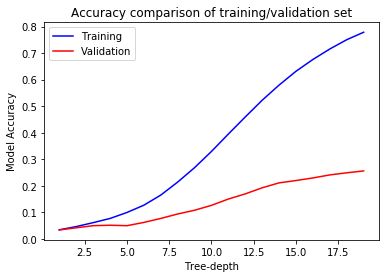

In [236]:
mean_train_score = np.mean(train_scores, axis=1) 
mean_val_score   = np.mean(valid_scores, axis=1)

plt.plot(max_depth_range, mean_train_score, color="blue", linewidth=1.5, label="Training")
plt.plot(max_depth_range, mean_val_score, color="red", linewidth=1.5, label="Validation")
plt.legend(loc="upper left")
plt.xlabel("Tree-depth")
plt.ylabel("Model Accuracy")
plt.title("Accuracy comparison of training/validation set")

### Regression

In [54]:
print(Xtrain.shape)
print(ytrain.shape)
print(Xtest.shape)
print(ytest.shape)

(1495, 3)
(1495,)
(641, 3)
(641,)


In [55]:
lr_model = LinearRegression()

lr_model.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [56]:
ypredicts = lr_model.predict(Xtest)

print("The predicted sales:")
print(ypredicts[:5])
print()
print("The true sales:")
print(ytest[:5])

The predicted sales:
[ 6668.51075331 21124.52962743  8503.3256094  20145.35855338
 11593.35813859]

The true sales:
151023     6950
26454     22902
50121      6995
35661     25000
189509     8500
Name: price, dtype: int64


In [57]:
mse = np.mean((ypredicts - ytest) ** 2)

print("MSE: {}".format(mse))

MSE: 10099096.061956333


In [58]:
print(lr_model.intercept_)
print(lr_model.coef_)

print(zip(feature_cols, lr_model.coef_))

-2240677.5502388105
[ 1.12224794e+03  0.00000000e+00 -1.16228163e-02]


In [71]:
def getErrorwithSize(model, train_sizes, Xtrain, ytrain, Xtest, ytest):
    
    # Initialize needed variables   
    model_mse   = np.zeros(len(train_sizes))  # storing model accuracy
    model_wts   = np.zeros([len(train_sizes), 4]) # storing model weights
    
    #Train our model with increasing data for each iteration
    for size in train_sizes:    
        Xsubtrain = Xtrain[0:size,:]
        ysubtrain = ytrain[0:size]
        model.fit(Xsubtrain, ysubtrain)
    
        # Test our model on fixed test set
        ypredicts = model.predict(Xtest)    
        
        index              = int(size/100)-1   
        model_mse[index]   = np.mean((ypredicts - ytest)**2)
        model_wts[index,:] = np.append(model.intercept_, model.coef_)  

    return model_mse, model_wts

In [72]:
train_sizes = np.arange(100,1500,100) # training size from 10 to 140
mse,weights = getErrorwithSize(lr_model,train_sizes, Xtrain.to_numpy(), ytrain.to_numpy(), Xtest.to_numpy(), ytest.to_numpy())
print(train_sizes)

[ 100  200  300  400  500  600  700  800  900 1000 1100 1200 1300 1400]


Text(0.5, 1.0, 'Effect of Data size on prediction error')

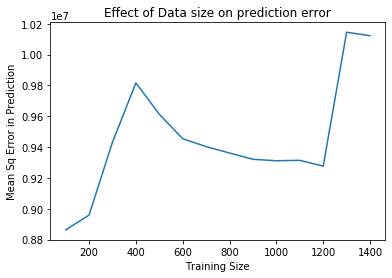

In [73]:
plt.plot(train_sizes, mse)
plt.xlabel('Training Size')
plt.ylabel('Mean Sq Error in Prediction')
plt.title('Effect of Data size on prediction error')

### Machine Learning

In [76]:
scaler = StandardScaler()
scaler.fit(Xtrain)
Xtrain = scaler.transform(Xtrain)
Xtest = scaler.transform(Xtest)

In [77]:
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30))

In [79]:
mlp.fit(Xtrain,ytrain)

C:\Users\lachlan.mcinnes\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(30, 30, 30), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [80]:
predictions = mlp.predict(Xtest)

In [82]:
print(confusion_matrix(ytest,predictions))

[[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [83]:
print(classification_report(ytest,predictions))

              precision    recall  f1-score   support

        1500       0.00      0.00      0.00         1
        1999       0.00      0.00      0.00         0
        2299       0.00      0.00      0.00         1
        2398       0.00      0.00      0.00         0
        2495       0.00      0.00      0.00         1
        2500       0.00      0.00      0.00         4
        2595       0.00      0.00      0.00         1
        2599       0.00      0.00      0.00         1
        2655       0.00      0.00      0.00         1
        2850       0.00      0.00      0.00         0
        2950       0.06      1.00      0.12         1
        2995       0.22      1.00      0.36         2
        3000       0.00      0.00      0.00         1
        3150       0.00      0.00      0.00         1
        3200       0.00      0.00      0.00         2
        3399       0.00      0.00      0.00         0
        3495       0.00      0.00      0.00         1
        3500       0.00    

C:\Users\lachlan.mcinnes\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lachlan.mcinnes\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
